In [46]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import os
from scipy.io import loadmat
import random

# 指定文件夹路径
download_save_path = '../Dataset/Data_Download'
exception_save_path = '../Dataset/Exception_Data'
plt_save_path = '../result/WSHR/figures'

# 获取文件夹下的所有文件名称
download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

In [62]:
# give the preset classification of determined variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "ABRK", "NSQT",
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", "TH", 
                       "TAS", "CASM", "GS",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = [
                   "FADS", 
                   
                   "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL",
                   "LGDN"]
var_group_control = ["HDGS", "PTRM", 
                     "RUDP", "CCPC", "CCPF", "CWPC", "CWPF",
                     "SNAP", 
                     "GPWS", "SHKR", "FADF"]
var_group_external = ["ALT", "WS", "WD", "PT", "TAT",
                      "LOC"]
var_group_recorder = ["PH"
                     ]
var_group_unclassified = ["EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "SMKB"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}
for group_name, var_group in var_groups_dict.items():
    group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(group_lens_dict.values())} variables in total")

# 查找给定总序数对应的变量名称
def find_var_name(idx, var_dict):
    count = 0
    group_lens_dict = {}
    for group_name, var_group in var_dict.items():
        group_lens_dict[group_name] = len(var_group)
    for group_name, var_group in var_dict.items():
        if count + group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += group_lens_dict[group_name]

mechanism: 25
power: 11
control: 11
external: 6
recorder: 1
unclassified: 7

61 variables in total


In [131]:
# Markov Random Field Model 构建

# 构建工作数据集
def generate_data(mat, var_groups_dict):
    data_array = []
    WSHR_len = len(mat['WSHR'][0][0][0])
    for group_name, var_list in var_groups_dict.items():
        for var_name in var_list:
            var_data, var_rate = mat[var_name][0][0][0], mat[var_name][0][0][1][0][0]
            # 依据WSHR长度对变量进行重采样
            if var_rate == 1:
                sampling_data = var_data
            # 进行下采样
            elif var_rate > 1:
                sampling_data = random.sample(var_data.tolist(), k=WSHR_len)
            # 进行过采样
            else:
                sampling_data = random.choices(var_data, k=WSHR_len)
            data_array.append(sampling_data)
    data_array = np.squeeze(np.array(data_array)).T

    return data_array

# 将变量间的线性相关性加入图G中
def build_graph(data, threshold):
    num_variables = data.shape[1]
    G = nx.Graph()
    
    for i in range(num_variables):
        G.add_node(i)
    
    for i in range(num_variables):
        for j in range(i+1, num_variables):
            correlation = np.corrcoef(data[:, i], data[:, j])[0, 1]
            
            if abs(correlation) > threshold:
                G.add_edge(i, j, weight=round(correlation,2))
                # print((i,j))
    
    return G

# 可视化无向图
def visualize_graph(G):
    plt.figure(figsize=(10, 10))

    # 移除没有边相连的孤立节点
    G.remove_nodes_from(list(nx.isolates(G)))

    # pos = nx.fruchterman_reingold_layout(G) # 调整布局
    # pos = nx.spiral_layout(G) # 螺旋布局
    # pos = nx.spring_layout(G) # 弹簧布局
    pos = nx.circular_layout(G) # 圆形布局
    
    # 绘制无向图
    nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=1500, edge_color='gray', width=1.5)

    # 绘制节点标签为对应变量名称
    node_labels = {i: find_var_name(i, var_groups_dict)[1] for i in range(sum(len(var_groups_dict[key]) for key in var_groups_dict.keys()))}
    # nx.set_node_attributes(G, '', 'label')
    nx.set_node_attributes(G, node_labels, 'label')
    node_labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels=node_labels)

    # 绘制连接线标签为线性相关度
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # 创建图例
    blue_patch = mpatches.Patch(color='lightblue', label='Nodes')
    gray_line = mlines.Line2D([], [], color='gray', linewidth=1.5, label='Edges')
    plt.legend(handles=[blue_patch, gray_line], loc='upper right')

    plt.show()


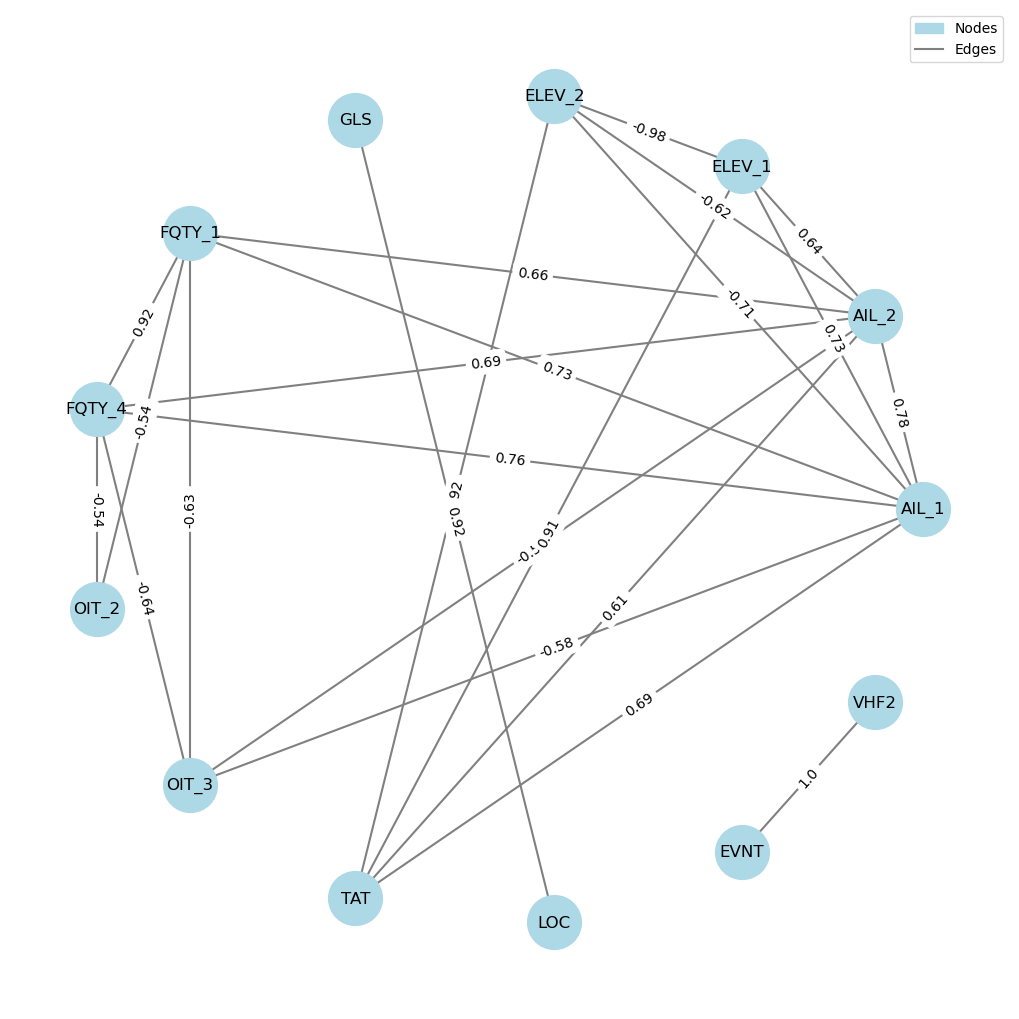

In [132]:
# 读取待选mat数据
exception_folder_path = exception_folder_paths[0]
work_mat = loadmat(os.path.join(exception_folder_path, os.listdir(exception_folder_path)[0]))

# 规定线性相关性阈值
threshold = 0.5

# 生成工作数据array
data_array = generate_data(work_mat, var_groups_dict)

G = build_graph(data_array, threshold)
visualize_graph(G)


In [112]:
# sum(len(var_groups_dict[key] for key in var_groups_dict.keys()))
list(var_groups_dict.keys())

['mechanism', 'power', 'control', 'external', 'recorder', 'unclassified']